In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from models.estimators._common import get_default_params

2024-09-06 16:00:42.959038: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def get_condition(params, defaults, name):
    if name == 'l1':
        cond = (params['alpha'] == defaults['alpha']) & (params['max_iter'] == defaults['max_iter'])
    elif name == 'l2':
        cond = (params['alpha'] == defaults['alpha']) & (params['max_iter'] == defaults['max_iter'])
    elif name == 'dt':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'rf':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'et':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    elif name == 'kr':
        cond = (params['alpha'] == defaults['alpha']) & (params['gamma'] == defaults['gamma']) & (params['kernel'] == defaults['kernel']) & (params['degree'] == defaults['degree'])
    elif name == 'cb':
        cond = (params['depth'] == defaults['depth']) & (params['l2_leaf_reg'] == defaults['l2_leaf_reg'])
    elif name == 'lgbm':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['reg_lambda'] == defaults['reg_lambda'])
    elif name == 'cf':
        cond = (params['max_depth'] == defaults['max_depth']) & (params['min_samples_leaf'] == defaults['min_samples_leaf'])
    else:
        raise ValueError("Unrecognised 'get_condition' key.")
    
    return cond

def get_base_id(est, bl, ds, defaults, file_prefix):
    model_name = f'{est}_{bl}'
    params = pd.read_csv(f'../results/predictions/{ds}/{model_name}/{file_prefix}_params.csv')
    cond = get_condition(params, defaults, bl)
    return int(params.loc[cond, 'id'])

def get_default_id(est, bl, ds):
    defaults = get_default_params(bl, ds)
    model_name = f'{est}_{bl}'

    if est in ['sl', 'ipsws', 'dmls', 'drs', 'xl']:
        id = get_base_id(est, bl, ds, defaults, model_name)
    elif est == 'tl':
        m0_id = get_base_id(est, bl, ds, defaults, f'{model_name}_m0')
        m1_id = get_base_id(est, bl, ds, defaults, f'{model_name}_m1')
        params = pd.read_csv(f'../results/predictions/{ds}/{model_name}/{model_name}_cate_params.csv')
        id = int(params.loc[(params['m0'] == m0_id) & (params['m1'] == m1_id), 'id'])
    elif est == 'cf':
        params = pd.read_csv(f'../results/predictions/{ds}/{est}/{est}_params.csv')
        cond = get_condition(params, defaults, est)
        id = int(params.loc[cond, 'id'])
    else:
        id = -1
    
    return id

def get_def_perf(est, bl, ds, test, targets):
    def_id = get_default_id(est, bl, ds)
    results = test.apply(lambda x: x.loc[x['param_id'] == def_id, targets])
    return [np.mean(results[target]) for target in targets]

def metric_by_best(df, by, target, lower_is_better):
    iter_gr = df.groupby(['iter_id'], as_index=False)

    if lower_is_better:
        best_by_iter = iter_gr.apply(lambda x: x.loc[x[by].idxmin(), [target]])
    else:
        best_by_iter = iter_gr.apply(lambda x: x.loc[x[by].idxmax(), [target]])

    return np.mean(best_by_iter[target])

def get_val_metric(df, target, best):
    return metric_by_best(df, f'{target}_val', f'{target}_test', best)

def get_val_oracle(df, targets):
    return [get_val_metric(df, target, True) for target in targets]

def get_val_worst(df, targets):
    return [get_val_metric(df, target, False) for target in targets]

def ax_worst_def_best(ds, targets, estmators, base_learners, ax, legend=False):
    all_perfs = []
    for est in estmators:
        if est == 'cf':
            df_test = pd.read_csv(f'../results/metrics_val/{ds}/{est}/{est}_test_metrics.csv')
            df_val = pd.read_csv(f'../results/metrics_val/{ds}/{est}/{est}_val_metrics.csv')
            df_val_gr = df_val.groupby(['iter_id', 'param_id'], as_index=False).mean().drop(columns=['fold_id'])
            df_base = df_val_gr.merge(df_test, on=['iter_id', 'param_id'], suffixes=['_val', '_test'])
            
            iter_gr = df_test.groupby(['iter_id'], as_index=False)
            def_perf = get_def_perf(est, est, ds, iter_gr, targets)

            oracle_perf = get_val_oracle(df_base, targets)
            worst_perf = get_val_worst(df_base, targets)
            all_perfs.append([*def_perf, 'default'])
            all_perfs.append([*worst_perf, 'worst'])
            all_perfs.append([*oracle_perf, 'best'])
        else:
            for bl in base_learners:
                model_name = f'{est}_{bl}'

                try:
                    df_test = pd.read_csv(f'../results/metrics_val/{ds}/{model_name}/{model_name}_test_metrics.csv')
                    df_val = pd.read_csv(f'../results/metrics_val/{ds}/{model_name}/{model_name}_val_metrics.csv')
                    df_val_gr = df_val.groupby(['iter_id', 'param_id'], as_index=False).mean().drop(columns=['fold_id'])
                    df_base = df_val_gr.merge(df_test, on=['iter_id', 'param_id'], suffixes=['_val', '_test'])
            
                    iter_gr = df_test.groupby(['iter_id'], as_index=False)
                except:
                    continue

                if bl != 'mlp':
                    def_perf = get_def_perf(est, bl, ds, iter_gr, targets)
                oracle_perf = get_val_oracle(df_base, targets)
                worst_perf = get_val_worst(df_base, targets)
                all_perfs.append([*def_perf, 'default'])
                all_perfs.append([*worst_perf, 'worst'])
                all_perfs.append([*oracle_perf, 'best'])

    df = pd.DataFrame(all_perfs, columns=[*targets, 'hyperparameters'])

    sns.scatterplot(data=df, x=targets[0], y=targets[1], hue='hyperparameters', ax=ax, legend=legend, s=40)

## Def-Oracle-Worst (All)

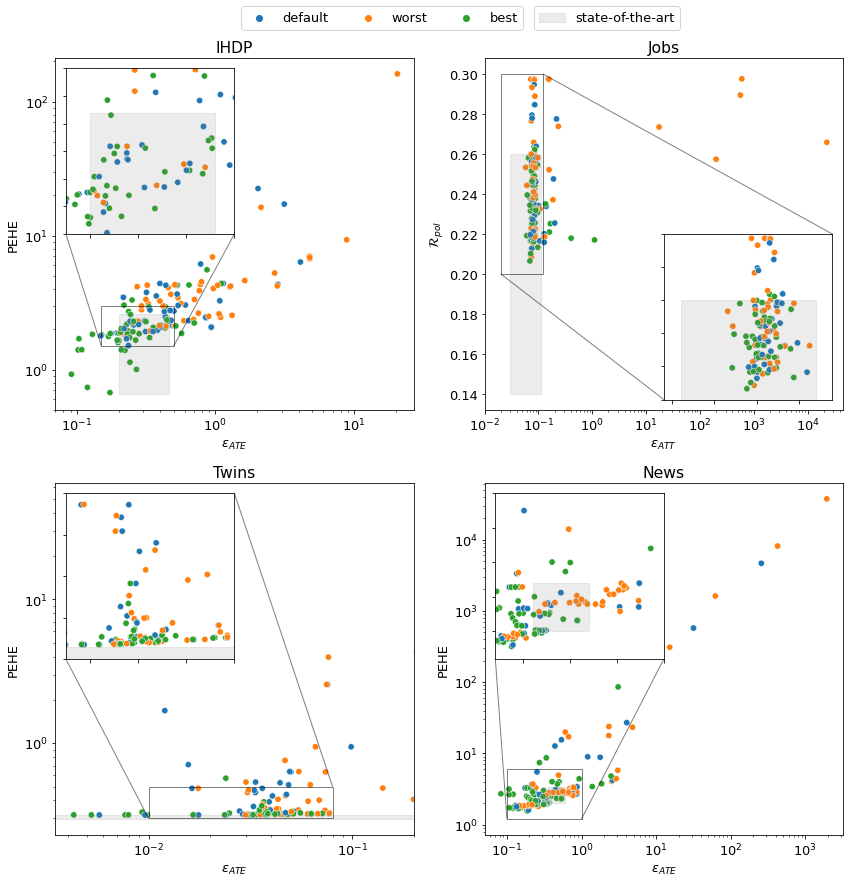

In [5]:
estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl', 'cf']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb', 'mlp']

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

sota_color = 'grey'
sota_alpha = 0.15

ax = axs[0][0]
ds = 'ihdp'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax)
ax.set_title('IHDP')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.03, 0.5, 0.47, 0.47])
ax_worst_def_best(ds, targets, estmators, base_learners, axins)
axins.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
axins.set_xlim(0.15, 0.5)
axins.set_ylim(1.5, 3.0)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = axs[0][1]
ds = 'jobs'
targets = ['att', 'policy']

ax_worst_def_best(ds, targets, estmators, base_learners, ax)
ax.set_title('Jobs')
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_ylabel('$\mathcal{R}_{pol}$')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.5, 0.03, 0.47, 0.47])
ax_worst_def_best(ds, targets, estmators, base_learners, axins)
axins.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
axins.set_xlim(0.02, 0.12)
axins.set_ylim(0.2, 0.3)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = axs[1][0]
ds = 'twins'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax)
ax.set_title('Twins')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(right=0.2)
ax.fill_between([0.0, 1.0], 0.297, 0.315, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.03, 0.5, 0.47, 0.47])
ax_worst_def_best(ds, targets, estmators, base_learners, axins)
axins.fill_between([0.0, 1.0], 0.297, 0.315, alpha=sota_alpha, color=sota_color)
axins.set_xlim(0.01, 0.08)
axins.set_ylim(0.3, 0.5)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = axs[1][1]
ds = 'news'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax, True)
ax.set_title('News')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.set_xscale('log')
ax.set_yscale('log')
sota_obj = ax.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.03, 0.5, 0.47, 0.47])
ax_worst_def_best(ds, targets, estmators, base_learners, axins)
axins.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
axins.set_xlim(0.1, 1.0)
axins.set_ylim(1.2, 6.0)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

lines, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(lines, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.45, 1.03))
fig.legend([sota_obj], ['state-of-the-art'], loc='upper center', bbox_to_anchor=(0.71, 1.03))

plt.tight_layout()
plt.savefig('worst_def_oracle_val.pdf', dpi=1000, bbox_inches="tight")

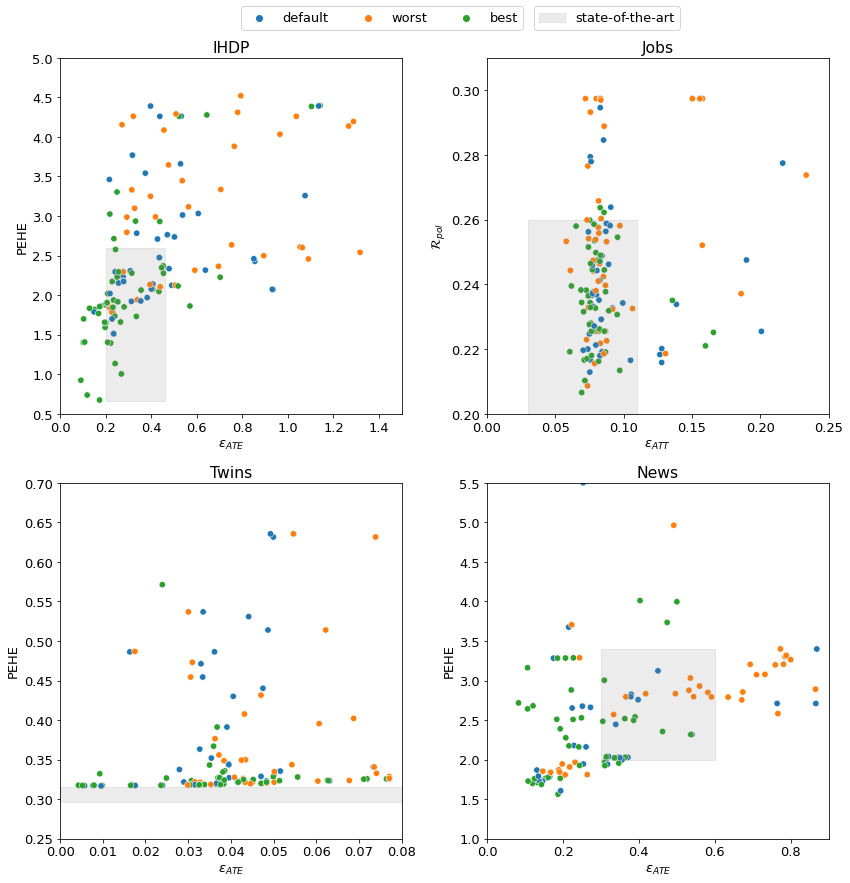

In [11]:
estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl', 'cf']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb', 'mlp']

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

sota_color = 'grey'
sota_alpha = 0.15

ax = axs[0][0]
ds = 'ihdp'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax)
ax.set_title('IHDP')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
ax.set_xlim(0.0, 1.5)
ax.set_ylim(0.5, 5.0)

ax = axs[0][1]
ds = 'jobs'
targets = ['att', 'policy']

ax_worst_def_best(ds, targets, estmators, base_learners, ax)
ax.set_title('Jobs')
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_ylabel('$\mathcal{R}_{pol}$')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
ax.set_xlim(0.0, 0.25)
ax.set_ylim(0.2, 0.31)

ax = axs[1][0]
ds = 'twins'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax)
ax.set_title('Twins')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.fill_between([0.0, 0.1], 0.297, 0.315, alpha=sota_alpha, color=sota_color)
ax.set_xlim(0.0, 0.08)
ax.set_ylim(0.25, 0.7)

ax = axs[1][1]
ds = 'news'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax, True)
ax.set_title('News')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
#ax.set_xscale('log')
#ax.set_yscale('log')
sota_obj = ax.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
ax.set_xlim(0.0, 0.9)
ax.set_ylim(1.0, 5.5)

lines, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(lines, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.45, 1.03))
fig.legend([sota_obj], ['state-of-the-art'], loc='upper center', bbox_to_anchor=(0.71, 1.03))

plt.tight_layout()
plt.savefig('hps_focus.pdf', dpi=1000, bbox_inches="tight")

## Def-Oracle-Worst (IHDP and Jobs)

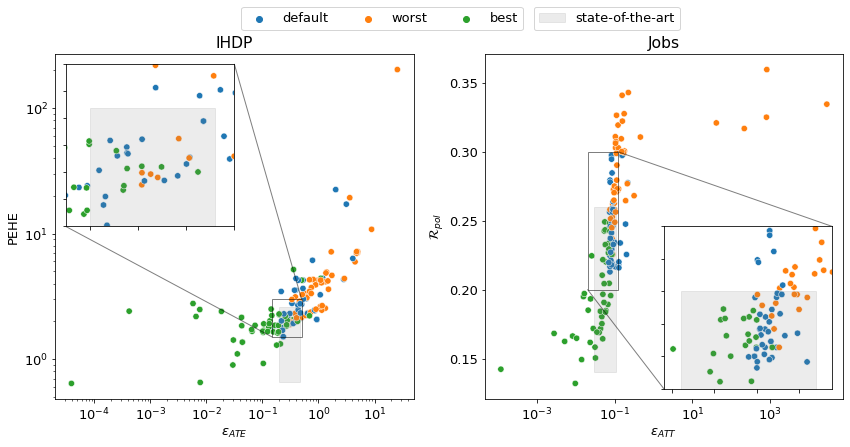

In [13]:
estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl', 'cf']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb', 'mlp']

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sota_color = 'grey'
sota_alpha = 0.15

ax = axs[0]
ds = 'ihdp'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax)
ax.set_title('IHDP')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.03, 0.5, 0.47, 0.47])
ax_worst_def_best(ds, targets, estmators, base_learners, axins)
axins.fill_between([0.2, 0.46], 0.656, 2.6, alpha=sota_alpha, color=sota_color)
axins.set_xlim(0.15, 0.5)
axins.set_ylim(1.5, 3.0)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = axs[1]
ds = 'jobs'
targets = ['att', 'policy']

ax_worst_def_best(ds, targets, estmators, base_learners, ax, True)
ax.set_title('Jobs')
ax.set_xlabel('$\epsilon_{ATT}$')
ax.set_ylabel('$\mathcal{R}_{pol}$')
ax.set_xscale('log')
#ax.set_yscale('log')
sota_obj = ax.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.5, 0.03, 0.47, 0.47])
ax_worst_def_best(ds, targets, estmators, base_learners, axins)
axins.fill_between([0.03, 0.11], 0.14, 0.26, alpha=sota_alpha, color=sota_color)
axins.set_xlim(0.02, 0.12)
axins.set_ylim(0.2, 0.3)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

lines, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(lines, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.45, 1.05))
fig.legend([sota_obj], ['state-of-the-art'], loc='upper center', bbox_to_anchor=(0.71, 1.05))

plt.tight_layout()
plt.savefig('hyper_ihdp_jobs.pdf', dpi=1000, bbox_inches="tight")

## Def-Oracle-Worst (Twins and News)

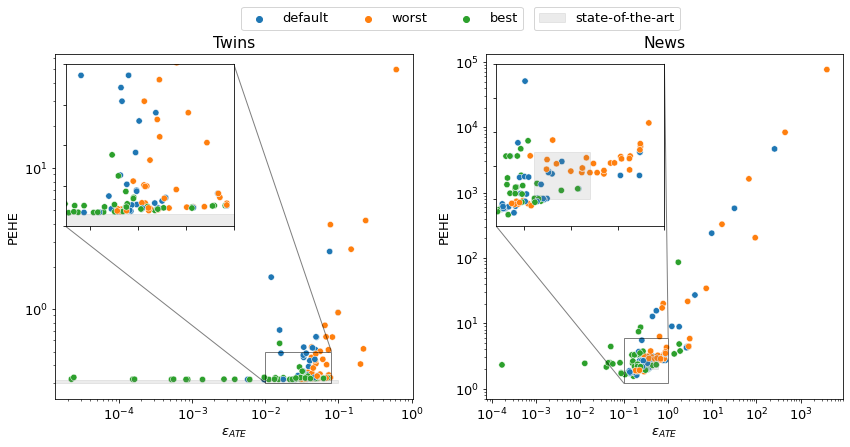

In [15]:
estmators = ['sl', 'tl', 'ipsws', 'dmls', 'drs', 'xl', 'cf']
base_learners = ['l1', 'l2', 'dt', 'rf', 'et', 'kr', 'lgbm', 'cb', 'mlp']

plt.rcParams.update({'font.size': 13})
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sota_color = 'grey'
sota_alpha = 0.15

ax = axs[0]
ds = 'twins'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax)
ax.set_title('Twins')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between([0.0, 0.1], 0.297, 0.315, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.03, 0.5, 0.47, 0.47])
ax_worst_def_best(ds, targets, estmators, base_learners, axins)
axins.fill_between([0.0, 0.1], 0.297, 0.315, alpha=sota_alpha, color=sota_color)
axins.set_xlim(0.01, 0.08)
axins.set_ylim(0.3, 0.5)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax = axs[1]
ds = 'news'
targets = ['ate', 'pehe']

ax_worst_def_best(ds, targets, estmators, base_learners, ax, True)
ax.set_title('News')
ax.set_xlabel('$\epsilon_{ATE}$')
ax.set_ylabel('PEHE')
ax.set_xscale('log')
ax.set_yscale('log')
sota_obj = ax.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
axins = ax.inset_axes([0.03, 0.5, 0.47, 0.47])
ax_worst_def_best(ds, targets, estmators, base_learners, axins)
axins.fill_between([0.3, 0.6], 2.0, 3.4, alpha=sota_alpha, color=sota_color)
axins.set_xlim(0.1, 1.0)
axins.set_ylim(1.2, 6.0)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xlabel('')
axins.set_ylabel('')
ax.indicate_inset_zoom(axins, edgecolor="black")

lines, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(lines, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.45, 1.05))
fig.legend([sota_obj], ['state-of-the-art'], loc='upper center', bbox_to_anchor=(0.71, 1.05))

plt.tight_layout()
plt.savefig('hyper_twins_news.pdf', dpi=1000, bbox_inches="tight")